In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

import src.functions.analysis.correlations_functions
# Import custom modules from project structure:
from utils import memory_handling as mh
from src.functions import analysis, acquisition, preprocessing
from src.functions.preprocessing.filtering_df import main as filtering
from src.functions.analysis.analysis_utils import main as plot
from src.functions.acquisition.scraping_speeches import main as scraping
from src.functions.preprocessing.adjust_speech_timestamp import adjust_timestamps as change_time
from src.functions.analysis.correlations_functions import calculate_pearson_coefficient as cpc


In [9]:
# --- Data Loading ---
yearlist = [2020, 2021, 2022, 2023, 2024]

# Load Fed speech data
fed_file = "2020-2024fedspeeches.pkl"
helper = mh.PickleHelper.pickle_load(fed_file)
df_fed = helper.obj
df_fed['speaker'] = df_fed['speaker'].str.replace('Speech - ', '', regex=False)
df_fed['speaker'] = df_fed['speaker'].str.replace('Discussion - ', '', regex=False)

# Load price data
prices_file = "2020-2024prices.pkl"
helper = mh.PickleHelper.pickle_load(prices_file)
df_prices = helper.obj
print("Price data columns:", df_prices.columns)
df_prices['date'] = df_prices['datetime'].dt.date

# Load speech data
speeches_file = "2020-2024speeches.pkl"
helper = mh.PickleHelper.pickle_load(speeches_file)
df_speech = helper.obj
df_speech = df_speech[df_speech['date'] >= '2020-01-01']
df_speech = df_speech.sort_values(['date', 'timestamp'], ascending=True)

# Load sentiment data
sentiment_file = "2020-2024sentiment.pkl"
helper = mh.PickleHelper.pickle_load(sentiment_file)
df_sentiment = helper.obj

# --- Adjust Speech Timestamps ---
# Rename Fed's 'timestamp' column to 'opening_time' for clarity
df_fed.rename(columns={'timestamp': 'opening_time'}, inplace=True)

# Update the correct timestamps for speech data using the adjust function
df_speech_final = change_time(df_speech, df_fed)  # This adjusts timestamps based on the Fed data
df_speech_final = df_speech_final.sort_values(['date', 'timestamp'], ascending=True)

# --- Filter Data Based on Market Hours ---
# Define market open/close times (ET)
market_open = pd.to_datetime('09:30:00', format='%H:%M:%S').time()
market_close = pd.to_datetime('16:00:00', format='%H:%M:%S').time()

# Extract time from timestamp for filtering
df_speech_final['time'] = df_speech_final['timestamp'].dt.time

# Calculate drop ratio when filtering out of market hours
before_filter_count = len(df_speech_final['text'].unique())
df_filtered = df_speech_final[(df_speech_final['time'] >= market_open) &
                              (df_speech_final['time'] < market_close)]
after_filter_count = len(df_filtered['text'].unique())

print(f"When filtering out data outside of market hours, the drop ratio is {(after_filter_count / before_filter_count) * 100:.2f}%")
print(f"We have dropped {before_filter_count - after_filter_count} values.")

# Remove the temporary 'time' column after filtering
df_speech_final = df_filtered.drop(columns=['time'])

# Assign final speech DataFrame for further processing
df_speech = df_speech_final

# Now, you can proceed with further analysis/plotting, for example:
# filtering(...)  or plot(...)


Price data columns: Index(['datetime', 'close', 'volume'], dtype='object')
Drop ratio: 16.16% (58 values dropped)
When filtering out data outside of market hours, the drop ratio is 66.45%
We have dropped 101 values.


The number of speeches shorter than 5 minutes is 19
No price data found for speech: Strengthening the Community Reinvestment Act by Staying True to Its Core Purpose by Governor Lael Brainard on 2020-01-08 00:00:00
No price data found for speech: The Outlook for Housing by Governor Michelle W. Bowman on 2020-01-16 00:00:00
No price data found for speech: Financial Markets and Monetary Policy: Is There a Hall of Mirrors Problem? by Vice Chair Richard H. Clarida on 2020-02-21 00:00:00
No price data found for speech: Monetary Policy Strategies and Tools When Inflation and Interest Rates Are Low by Governor Lael Brainard on 2020-02-21 00:00:00
No price data found for speech: U.S. Economic Outlook and Monetary Policy by Vice Chair Richard H. Clarida on 2020-02-25 00:00:00
No price data found for speech: New Economic Challenges and the Fed's Monetary Policy Review by Chair Jerome H. Powell on 2020-08-27 00:00:00
No price data found for speech: Remarks at the Hoover Institution by Vice Chair f

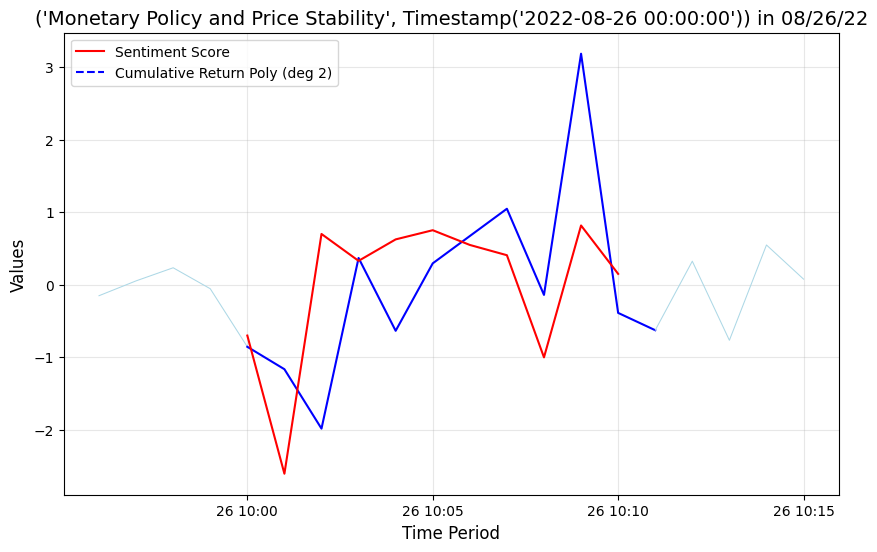

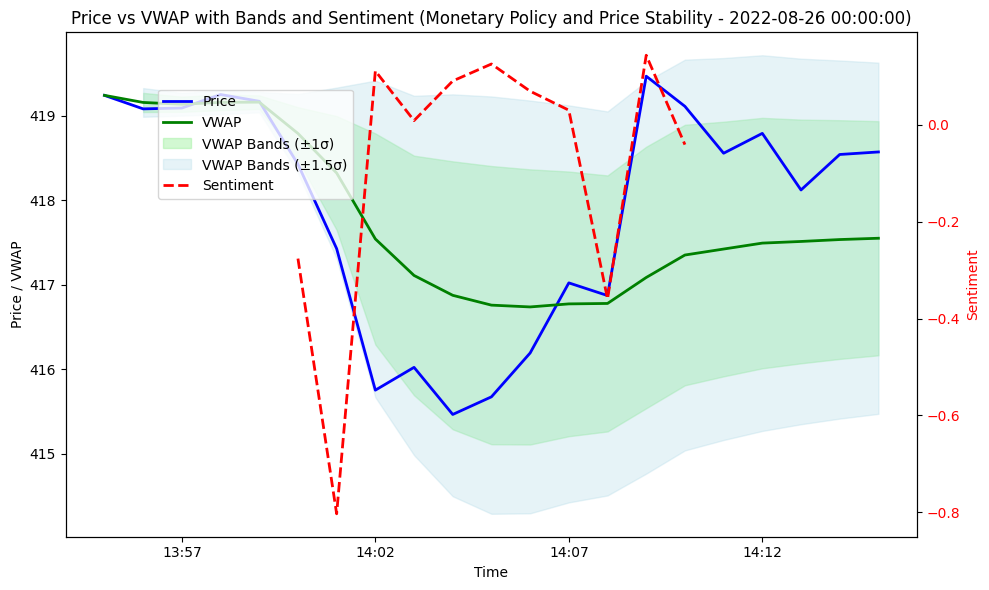

Thank you for t 





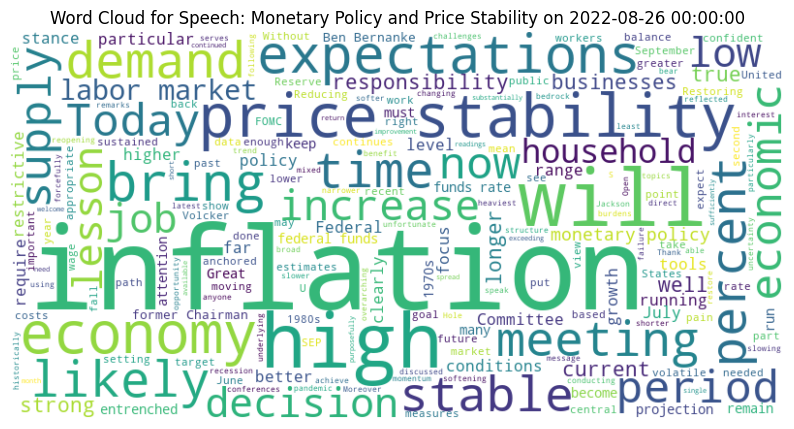

In [10]:
# --- Combine DataFrames and Merge Sentiment/Pct Change Data ---

# Set the time deltas for including extra data before and after the speech event
deltabefore = 5   # minutes before the speech
deltaafter = 4    # minutes after the speech

# Filter and merge price, speech, and sentiment data using the custom filtering function.
# Note: This function returns two DataFrames:
#   - df_speech_final: Speech data with sentiment and time-adjusted values.
#   - df_prices_final: Price data with calculated percentage changes.
df_speech_final, df_prices_final = filtering(df_prices, df_speech, df_sentiment, deltabefore, deltaafter)
print(f"Filtered data: {df_speech_final.shape[0]} speech rows and {df_prices_final.shape[0]} price rows.")

# --- Plot Volatility Analysis ---

# Plot the top volatility event (or events) based on the speech time,
# using the provided plotting function.
# Here, 'top_n=1' selects the best event.
plot(df_speech_final, deltabefore, deltaafter, top_n=1)


In [12]:
def plot_scatter(sp500_data, sentiment_data):
    """
    Create a scatter plot to visualize the relationship between S&P500 data and sentiment,
    with different colors for each dataset.

    Parameters:
    sp500_data (list or np.array): Minute-by-minute S&P500 data.
    sentiment_data (list or np.array): Minute-by-minute sentiment data.
    """
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for S&P500 data
    plt.scatter(range(len(sp500_data)), sp500_data, color='blue', alpha=0.5, label='S&P500')
    
    # Scatter plot for sentiment data
    plt.scatter(range(len(sentiment_data)), sentiment_data, color='red', alpha=0.5, label='Sentiment')
    
    plt.title('Scatter Plot of S&P500 and Sentiment Over Time')
    plt.xlabel('Time (Minutes)')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [13]:
def find_best_volatility(top_n, df_speech):
    # Drop rows with missing values
    df = df_speech.dropna()
    
    # Create a dictionary to store volatilities and indices
    volatility_dict = {}
    index_dict = {}  # To store indices for each link
    
    # Get the unique list of links
    linklist = df['link'].unique().tolist()
    
    # Calculate the volatility for each link and track indices
    for link in linklist:
        # Calculate volatility
        volatility = df[df['link'] == link]['pct_change'].std()
        volatility_dict[link] = volatility
        
        # Track indices for the link
        indices = df[df['link'] == link].index.tolist()
        if len(indices) > 0:
            indices.append(indices[-1] + 1)  # Append the next index (for t+1)
        index_dict[link] = indices  # Store indices for the link
    
    # Convert the volatility dictionary to a DataFrame
    store_df = pd.DataFrame.from_dict(volatility_dict, orient='index', columns=['volatility'])
    
    # Sort by volatility in descending order
    store_df = store_df.sort_values(by='volatility', ascending=False)
    
    # Select the top N links with the highest volatility
    top_links = store_df.head(top_n).index.tolist()  # Get the top N links
    
    # Collect all indices associated with the top N links
    filtered_indices = []
    for link in top_links:
        filtered_indices.extend(index_dict[link])  # Add the indices of the link
    
    # Filter the original DataFrame by the collected indices
    filtered_df = df_speech.loc[filtered_indices]  # Use `.loc` for index filtering
    
    return filtered_df


In [14]:
#overall

score, scoret1 = cpc(df_speech_final)
print('overall scores are' ,score , scoret1)

#best volatility speeches
df_volatility=find_best_volatility(5,df_speech_final)

scorevol,scorevolt = cpc(df_volatility)
print('scores for best volatility speeches are',scorevol,scorevolt)

# 2020
df2020 = df_speech_final[(df_speech_final['date'] >= '2020-01-01') & (df_speech_final['date'] <= '2020-12-31')]
score2020, score2020t = cpc(df2020)
print('scores for 2020 are', score2020, score2020t)

# 2021
df2021 = df_speech_final[(df_speech_final['date'] >= '2021-01-01') & (df_speech_final['date'] <= '2021-12-31')]
score2021, score2021t = cpc(df2021)
print('scores for 2021 are', score2021, score2021t)

# 2022
df2022 = df_speech_final[(df_speech_final['date'] >= '2022-01-01') & (df_speech_final['date'] <= '2022-12-31')]
score2022, score2022t = cpc(df2022)
print('scores for 2022 are', score2022, score2022t)

# 2023
df2023 = df_speech_final[(df_speech_final['date'] >= '2023-01-01') & (df_speech_final['date'] <= '2023-12-31')]
score2023, score2023t = cpc(df2023)
print('scores for 2023 are', score2023, score2023t)

# 2024
df2024 = df_speech_final[(df_speech_final['date'] >= '2024-01-01') & (df_speech_final['date'] <= '2024-12-31')]
score2024, score2024t = cpc(df2024)
print('scores for 2024 are', score2024, score2024t)

Error processing link /newsevents/speech/brainard20210113a.htm: '[25] not in index'
Error processing link /newsevents/speech/waller20211217a.htm: '[62] not in index'
Error processing link /newsevents/speech/waller20240116a.htm: '[93] not in index'
Error processing link /newsevents/speech/brainard20200813a.htm: '[114] not in index'
Error processing link /newsevents/speech/cook20241001a.htm: '[141] not in index'
Error processing link /newsevents/speech/bowman20240403a.htm: '[176] not in index'
Error processing link /newsevents/speech/bowman20240402a.htm: '[210] not in index'
Error processing link /newsevents/speech/quarles20211202a.htm: '[267] not in index'
Error processing link /newsevents/speech/bowman20231018a.htm: '[284] not in index'
Error processing link /newsevents/speech/brainard20220907a.htm: '[310] not in index'
Error processing link /newsevents/speech/brainard20200901a.htm: '[338] not in index'
Error processing link /newsevents/speech/bowman20241002a.htm: '[387] not in index'


ZeroDivisionError: Weights sum to zero, can't be normalized